In [1]:
import os
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from xgboost import XGBClassifier
from datetime import datetime

## 0. Mount to Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Customs-Declaration-Datasets-en/

Mounted at /content/drive
/content/drive/MyDrive/Customs-Declaration-Datasets-en


## 1. Load Dataset 

In [2]:
X_train = pd.read_csv('./data_enc/encoded_train_eng.csv')
X_valid = pd.read_csv('./data_enc/encoded_valid_eng.csv')

In [3]:
y_train= pd.read_csv('./data_enc/y_train_eng.csv')
y_valid= pd.read_csv('./data_enc/y_valid_eng.csv')

In [4]:
X_train

,Office ID,Process Type,Import Type,Import Use,Payment Type,Mode of Transport,Declarant ID,Importer ID,Seller ID,Courier ID,HS6 Code,Country of Departure,Country of Origin,Tax Rate,Tax Type,Country of Origin Indicator,Net Mass,Item Price
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1.799250e-06,5.283441e-05
1,2,1,1,1,1,2,2,2,2,1,2,2,2,2,2,2,1.891212e-04,5.333071e-05
2,3,1,1,1,1,2,3,3,3,1,3,2,2,3,3,3,3.448563e-07,7.597590e-07
3,2,1,1,1,2,2,4,4,4,1,4,3,3,1,4,2,1.535693e-04,2.097236e-04
4,3,1,1,1,1,1,5,5,5,1,5,3,3,4,2,3,3.998334e-04,9.033619e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37380,2,1,1,1,2,2,129,5031,428,1,27,2,2,5,4,2,9.546022e-06,4.879585e-08
37381,3,1,4,6,2,1,329,7703,369,1,26,2,2,10,3,1,3.228655e-05,4.978624e-06
37382,2,1,1,1,1,1,337,158,1110,1,123,2,2,38,8,4,8.329863e-07,4.406955e-07
37383,3,1,1,1,1,2,110,12719,2370,1,449,11,9,1,2,3,3.415577e-04,4.422999e-05


## 2. Over sampling

In [5]:
from imblearn.over_sampling import RandomOverSampler

In [6]:
# Random oversampling
over_sampler = RandomOverSampler(random_state = 11)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)

In [7]:
print("Before oversampling:")
print(y_train.value_counts())
print("\nAfter oversampling:")
print(y_train_over.value_counts())

Before oversampling:
Fraud
0        29271
1         8114
dtype: int64

After oversampling:
Fraud
1        29271
0        29271
dtype: int64


In [8]:
# formatting data
y_train_over = np.array(y_train_over).ravel()
y_valid = np.array(y_valid).ravel()

## 3. Train XGBoost model

In [9]:
xgb_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5994130001745845, max_delta_step=0, max_depth=4,
              min_child_weight=2,
              n_estimators=424, n_jobs=20, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=0, objective= 'binary:logistic', eval_metric='logloss')

In [10]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [11]:
from sklearn.metrics import confusion_matrix,precision_score,accuracy_score,recall_score,f1_score,roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average ='macro')
    recall = recall_score(y_test, pred, average ='macro')
    f1 = f1_score(y_test, pred, average ='macro')
    
    print("confusion\n", confusion)
    print("Accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f}, F1:{3:.4f}\n".format(accuracy, precision, recall, f1))
  

In [12]:
def get_model_train_eval(model, ftr_train = None, ftr_test = None, tgt_train = None, tgt_test = None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [13]:
start_time = timer(None) 

get_model_train_eval(xgb_model, ftr_train = X_train_over, ftr_test = X_valid, 
                      tgt_train = y_train_over, tgt_test = y_valid)
timer(start_time) 

/home/intern/chaeyoon/anaconda3/envs/wco/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


confusion
 [[5448  982]
 [ 657 1047]]
Accuracy: 0.7985, precision: 0.7042, recall: 0.7309, F1:0.7151


 Time taken: 0 hours 0 minutes and 2.58 seconds.


## 4. Save trained model

In [14]:
import pickle
file_name = "./model/xgb_reg_eng.pkl"
os.makedirs('./model/', exist_ok = True)

# save
pickle.dump(xgb_model, open(file_name, "wb"))

## 5. Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

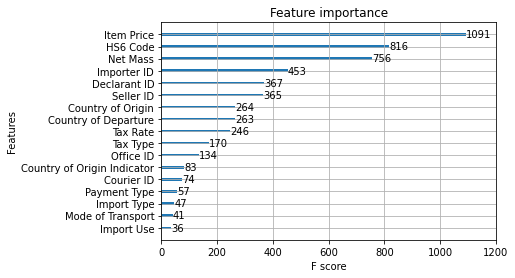

In [15]:
%matplotlib inline
from xgboost import plot_importance

plot_importance(xgb_model, max_num_features=20)

## 6. Evaluate model performance by comparing Prediction Result & Ground Truth

In [16]:
X_test = pd.read_csv('./data_enc/encoded_test_eng.csv')
y_test = pd.read_csv('./data_enc/y_test_eng.csv')

import pickle
file_name = "./model/xgb_reg_eng.pkl"

# load
xgb_model = pickle.load(open(file_name, "rb"))

pred_test = xgb_model.predict(X_test)
get_clf_eval(y_test, pred_test, None)

confusion
 [[5638 1008]
 [ 704 1131]]
Accuracy: 0.7981, precision: 0.7089, recall: 0.7323, F1:0.7187



In [17]:
df_test = pd.read_csv('./data/df_syn_test_eng.csv')
df_test["Fraud_Prediction"] = pred_test
df_test.to_csv('./data/predict_test_eng.csv', index=None)